In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats
from scipy.stats import linregress
np.random.seed(1265)
from functools import reduce
from mpl_toolkits.basemap import Basemap
import geopandas as gpd
from shapely.geometry import Point, MultiPolygon, Polygon
from shapely.ops import unary_union
import os

###Machine Learning
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

##Supervised Learning
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostRegressor
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb

##Deep learning session
import tensorflow as tf
from keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adagrad

np.random.seed(123)
tf.random.set_seed(123)

# Predicting housing price with each DL separately

#### Prepare the data

In [2]:
string_brackets_columns = ['resoFacts.patioAndPorchFeatures', 'resoFacts.waterSource', 'resoFacts.exteriorFeatures',
                           'resoFacts.interiorFeatures', 'resoFacts.communityFeatures', 'resoFacts.constructionMaterials',
                           'resoFacts.foundationDetails', 'resoFacts.utilities', 'resoFacts.appliances', 
                           'resoFacts.flooring', 'resoFacts.parkingFeatures',
                           'resoFacts.lotFeatures', 'resoFacts.fireplaceFeatures', 'resoFacts.laundryFeatures', 
                           'resoFacts.propertySubType', 'resoFacts.securityFeatures', 
                           'resoFacts.cooling', 'resoFacts.windowFeatures', 'resoFacts.heating', 'resoFacts.sewer', 
                           'resoFacts.poolFeatures']

string_comma_columns = ['resoFacts.architecturalStyle', 
                        'resoFacts.fencing', 'resoFacts.roofType']

t = string_brackets_columns + string_comma_columns
Selected_features = list(set(t) - set(['resoFacts.utilities', 'resoFacts.propertySubType']))

Year_list2022 = ['2022']
Month_list2022 = ['July', 'August', 'September', 'October', 'November', 'December']
Year_list2023 = ['2023']
Month_list2023 = ['January', 'February', 'March']

##This is a dictionary that stores the original data everymonth
original_data = dict()

##This is a dictionary that store the datasets for every month
monthly_data_dict1 = dict()

##This is a dictionary that store datasets to run analysis
monthly_data_dict2 = dict()
path_abs = "C:\\Users\\Khoatruong\\DATA365\\House Capstone Project\\Data cleaning\\Houses_categorical_property\\"

##Remove zipcode, city, county, SchoolDistrict since longitude and latitude will do the part

def read_house_data(Monthlist, Yearlist, original_data, monthly_data_dict1, monthly_data_dict2):
    for Year in Yearlist:
        for Month in Monthlist:
            main_df = pd.read_csv("C:\\Users\\Khoatruong\\DATA365\\House Capstone Project\\Data cleaning\\Clean_data_House_properties\\" + Month + '_' + Year + '\\houses_properties_' + Month + '.csv')
            cols = main_df.columns.tolist()

            ##Rename some columns
            for c in cols:
                if 'resoFacts.' in c:
                    feature = c.split('.')[1]
                    main_df[feature] = main_df[c]
                    main_df.drop(labels = [c], axis = 1, inplace = True)

            ##Drop unimportant features 
            main_df.drop(labels = ['streetAddress', 'countyId', 'hasCooling', 'hasHeating'], axis = 1, inplace = True)
            main_df.reset_index(drop = True, inplace = True)

            ##Join the categorical dataframes
            for category in Selected_features:
                ft = category.split('.')[1]
                name = 'houses' + '_' + ft + '.csv'
                df_cat = pd.read_csv(path_abs + Month + '_' + Year + '\\' + name)
                main_df = pd.merge(main_df, df_cat, how = 'left', on = 'zpid')

            string_list = ['city', 'county', 'SchoolDistrict', 'levels']
            for string in string_list:
                main_df[string] = main_df[string].str.lower()
            original_data[Month + '_' + Year] = main_df

            ##Need the zpid (zillow id) to keep track of the data
            #main_df.drop(labels = ['zpid'], axis = 1, inplace = True)
            monthly_data_dict1[Month + '_' + Year] = main_df

            remove_features = ['zipcode', 'city', 'SchoolDistrict', 'annualHomeownersInsurance']
            main_df2 = main_df.copy()
            main_df2.drop(labels = remove_features, axis = 1, inplace = True)
            monthly_data_dict2[Month + '_' + Year] = main_df2

In [3]:
read_house_data(Month_list2022, Year_list2022, original_data, monthly_data_dict1, monthly_data_dict2)
read_house_data(Month_list2023, Year_list2023, original_data, monthly_data_dict1, monthly_data_dict2)

In [4]:
for Month, df in monthly_data_dict1.items():
    monthly_data_dict1[Month]['zipcode'] = monthly_data_dict1[Month]['zipcode'].astype('int64')

for Month, df in monthly_data_dict1.items():
    monthly_data_dict1[Month]['price/livingsqft'] = monthly_data_dict1[Month]['price'] / monthly_data_dict1[Month]['livingAreaValue']
    monthly_data_dict1[Month]['price/lotsqft'] = monthly_data_dict1[Month]['price'] / monthly_data_dict1[Month]['lotArea']
    monthly_data_dict1[Month]['liv/lot_ratio'] = monthly_data_dict1[Month]['livingAreaValue'] / monthly_data_dict1[Month]['lotArea']
    monthly_data_dict1[Month]['living_price'] = df.apply(lambda row: row['price'] if row['liv/lot_ratio'] >= 1 else row['liv/lot_ratio']*row['price'], axis=1)
    levels_df = pd.get_dummies(monthly_data_dict1[Month]['levels'], prefix = 'levels')
    df = pd.concat([df.copy(), levels_df], axis=1)
    df = df.copy().drop('levels', axis = 1)
    df = df.copy().drop(df[(df['lotArea'] == 0) | (df['price/lotsqft'] > 1000) | (df['liv/lot_ratio'] > 2)].index)
    monthly_data_dict1[Month] = df

In [5]:
##Need to categorize levels
True_False_features = ['isSeniorCommunity', 'hasAssociation', 'hasPrivatePool', 'hasGarage',
                       'hasAttachedGarage', 'hasCarport', 'hasSpa', 'hasFireplace', 'isNewConstruction']

Numerical_features = ['monthlyHoaFee', 'liv/lot_ratio', 'bedrooms', 'carportSpaces', 'garageSpaces', 
                      'coveredSpaces', 'parking', 'bathroomsHalf', 'bathroomsFull', 'fireplaces']

##levels, laundry features, flooring features, construction features, exterior features, interior features, appliances,
##foundations, lotFeatures, securityFeatures, sewer of the house.

Categorical_features = ['levels_one', 'levels_one and one half', 'levels_two', 'levels_three or more',
                        'levels_multi/split', 'laundryFeatures_none', 'laundryFeatures_electricdryerhookup',
                        'laundryFeatures_fullsizew/darea', 'laundryFeatures_washerhookup', 'laundryFeatures_utilityroom',
                        'laundryFeatures_other', 'flooring_carpet', 'flooring_laminate', 'flooring_vinyl',
                        'flooring_ceramictile', 'flooring_hardwood', 'flooring_other', 'flooring_luxuryvinylplank',
                        'flooring_tile', 'flooring_wood', 'constructionMaterials_siding', 'constructionMaterials_wood',
                        'constructionMaterials_brick', 'constructionMaterials_other', 'constructionMaterials_frame',
                        'constructionMaterials_fibercement', 'constructionMaterials_rock/stone', 'exteriorFeatures_coveredpatio/porch',
                        'exteriorFeatures_storage', 'exteriorFeatures_other', 'exteriorFeatures_raingutters',
                        'exteriorFeatures_lighting', 'exteriorFeatures_privateyard', 'interiorFeatures_granitecounters',
                        'interiorFeatures_highspeedinternetavailable', 'interiorFeatures_other', 'interiorFeatures_cabletvavailable',
                        'interiorFeatures_eat-inkitchen', 'interiorFeatures_pantry', 'interiorFeatures_openfloorplan',
                        'interiorFeatures_kitchenisland', 'interiorFeatures_vaultedceiling(s)', 
                        'interiorFeatures_walk-incloset(s)', 'interiorFeatures_built-infeatures', 'interiorFeatures_decorativelighting',
                        'interiorFeatures_smarthomesystem', 'interiorFeatures_doublevanity', 'interiorFeatures_flatscreenwiring',
                        'interiorFeatures_chandelier', 'interiorFeatures_soundsystemwiring', 'interiorFeatures_wetbar',
                        'appliances_electricrange', 'appliances_refrigerator', 'appliances_gasrange', 'appliances_dishwasher',
                        'appliances_gasoven', 'appliances_gaswaterheater', 'appliances_electricoven', 'appliances_microwave',
                        'appliances_electriccooktop', 'appliances_electricwaterheater', 'appliances_ventedexhaustfan',
                        'appliances_disposal', 'appliances_plumbedforgasinkitchen', 'appliances_tanklesswaterheater',
                        'appliances_gascooktop', 'appliances_doubleoven', 'appliances_convectionoven', 'appliances_built-ingasrange', 
                        'appliances_other', 'foundationDetails_pillar/post/pier', 'foundationDetails_slab',
                        'foundationDetails_other', 'lotFeatures_lrg.backyardgrass', 'lotFeatures_acreage',
                        'lotFeatures_cornerlot', 'lotFeatures_fewtrees', 'lotFeatures_none', 'lotFeatures_interiorlot',
                        'lotFeatures_subdivided', 'lotFeatures_cul-de-sac', 'lotFeatures_landscaped',
                        'lotFeatures_sprinklersystem', 'lotFeatures_other', 'lotFeatures_manytrees',
                        'securityFeatures_none', 'securityFeatures_smokedetector(s)', 'securityFeatures_carbonmonoxidedetector(s)',
                        'securityFeatures_firealarm', 'securityFeatures_securitysystem',
                        'securityFeatures_securitysystemowned', 'securityFeatures_burglar', 'securityFeatures_prewired',
                        'securityFeatures_other', 'sewer_citysewer', 'sewer_aerobicseptic', 'sewer_septic',
                        'sewer_other']

In [6]:
Month_list = ['July_2022', 'August_2022', 'September_2022', 'October_2022', 'November_2022',
              'December_2022', 'January_2023', 'February_2023', 'March_2023']
monthly_location_dict1 = dict()

for month in Month_list:
    ###Read in all the datasets
    Month_path = 'Location_data3/' + month + '/' + month + '_houses_location.csv'
    df_location = pd.read_csv(Month_path)
    monthly_location_dict1[month] = df_location

In [7]:
monthly_location_dict1['August_2022']

,zpid,latitude,longitude,county_lat,county_long,SD_lat,SD_long,zipcode_lat,zipcode_long,price/livingsqft,price/lotsqft,liv/lot_ratio
0,2.201112e+08,33.245920,-97.834140,33.219095,-97.653997,33.157978,-97.816943,33.160060,-97.840034,242.236025,23.560969,0.097265
1,2.201135e+08,33.192272,-97.896126,33.219095,-97.653997,33.267840,-98.132984,33.160060,-97.840034,114.246640,16.060247,0.140575
2,2.201123e+08,32.999400,-97.488280,33.219095,-97.653997,33.033006,-97.354880,33.011335,-97.474362,105.623100,10.360393,0.098088
3,2.062150e+09,33.039154,-97.756805,33.219095,-97.653997,33.157978,-97.816943,32.970044,-97.733748,106.666667,3.673095,0.034435
4,2.200980e+08,33.292850,-97.796005,33.219095,-97.653997,33.326269,-97.829165,33.302787,-97.868426,141.242938,3.210747,0.022732
...,...,...,...,...,...,...,...,...,...,...,...,...
14456,2.063034e+09,32.453842,-96.961170,32.346878,-96.796940,32.472297,-97.000465,32.469436,-96.990670,240.822695,101.500325,0.421473
14457,2.736100e+07,32.318490,-96.635216,32.346878,-96.796940,32.322460,-96.571442,32.323939,-96.590285,659.750733,6.920892,0.010490
14458,3.312331e+08,32.348778,-96.840440,32.346878,-96.796940,32.356339,-96.863493,32.371654,-96.803030,264.900662,28.466483,0.107461
14459,2.062626e+09,32.454185,-96.960724,32.346878,-96.796940,32.472297,-97.000465,32.469436,-96.990670,231.852575,109.033517,0.470271


In [8]:
monthly_data_dict1['August_2022']

,zpid,annualHomeownersInsurance,monthlyHoaFee,livingAreaValue,bedrooms,longitude,latitude,zipcode,city,mortgageRates.fifteenYearFixedRate,...,interiorFeatures_wetbar,price/livingsqft,price/lotsqft,liv/lot_ratio,living_price,levels_multi/split,levels_one,levels_one and one half,levels_three or more,levels_two
0,2.201112e+08,819.0,4.0,805.0,2.0,-97.834140,33.245920,76426,bridgeport,4.832,...,0,242.236025,23.560969,0.097265,18966.579672,0,1,0,0,0
1,2.201135e+08,714.0,0.0,1488.0,3.0,-97.896126,33.192272,76426,runaway bay,4.832,...,0,114.246640,16.060247,0.140575,23897.647632,0,0,0,0,1
2,2.201123e+08,584.0,0.0,1316.0,3.0,-97.488280,32.999400,76071,newark,4.832,...,0,105.623100,10.360393,0.098088,13634.276651,0,1,0,0,0
3,2.062150e+09,672.0,0.0,1500.0,1.0,-97.756805,33.039154,76082,springtown,4.832,...,0,106.666667,3.673095,0.034435,5509.641873,0,0,0,0,1
4,2.200980e+08,840.0,0.0,1416.0,2.0,-97.796005,33.292850,76431,chico,4.832,...,0,141.242938,3.210747,0.022732,4546.417770,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14711,2.063034e+09,3565.0,163.0,3525.0,4.0,-96.961170,32.453842,76065,midlothian,4.767,...,0,240.822695,101.500325,0.421473,357788.646407,0,1,0,0,0
14712,2.736100e+07,3780.0,0.0,1364.0,2.0,-96.635216,32.318490,75119,ennis,4.767,...,0,659.750733,6.920892,0.010490,9440.096103,0,1,0,0,0
14713,3.312331e+08,5208.0,0.0,4681.0,4.0,-96.840440,32.348778,75165,waxahachie,4.767,...,0,264.900662,28.466483,0.107461,133251.606979,0,0,0,0,1
14714,2.062626e+09,3990.0,83.0,4097.0,5.0,-96.960724,32.454185,76065,midlothian,4.767,...,0,231.852575,109.033517,0.470271,446710.319100,0,0,0,0,1


In [9]:
def transform_data(df, True_False_features, Numerical_features, Categorical_features):
    df_transformed = df.copy()
    for ft in True_False_features:
        df_transformed.loc[df_transformed[ft] == True, ft] = 1
        df_transformed.loc[df_transformed[ft] == False, ft] = 0
        df_transformed[ft] = df_transformed[ft].astype(int)
    return df_transformed[True_False_features + Numerical_features + Categorical_features + ['living_price']]

In [10]:
###df_model1, train_set_dict1, etc. represent the location data
###df_model2, train_set_dict2, etc. represent the properties data
###original_df represents the initial dataframes with all raw features

def prep_combination_data(splits, scaler, original_df, df_model1, df_model2, Numerical_features):
    data1 = df_model1.to_numpy()
    data2 = df_model2.to_numpy()
    cv = KFold(n_splits = splits, shuffle = True, random_state = 0)
    cv.split(data1)

    train_set_dict1 = dict()
    train_target_dict1 = dict()
    scaled_train_set1 = dict()
    scaled_train_target1 = dict()

    test_set_dict1 = dict()
    test_target_dict1 = dict()
    scaled_test_set1 = dict()
    scaled_test_target1 = dict()
    
    train_set_dict2 = dict()
    train_target_dict2 = dict()
    scaled_train_set2 = dict()
    scaled_train_target2 = dict()

    test_set_dict2 = dict()
    test_target_dict2 = dict()
    scaled_test_set2 = dict()
    scaled_test_target2 = dict()

    ###Create 2 different unique dictionary to track the prediction of real price
    original_train = dict()
    original_test = dict()
    
    ###Store K folds data into dictionary
    for i, (train_index, test_index) in enumerate(cv.split(data1)):
        ###1 means location data
        train_set1 = df_model1.iloc[train_index].iloc[:, :-1]
        train_target1 = df_model1.iloc[train_index].iloc[:, -1]
        train_set_dict1['Fold ' + str(i)] = train_set1.copy()
        train_target_dict1['Fold ' + str(i)] = train_target1.copy()

        test_set1 = df_model1.iloc[test_index].iloc[:, :-1]
        test_target1 = df_model1.iloc[test_index].iloc[:, -1]
        test_set_dict1['Fold ' + str(i)] = test_set1.copy()
        test_target_dict1['Fold ' + str(i)] = test_target1.copy()
        
        ###2 means properties data
        train_set2 = df_model2.iloc[train_index].iloc[:, :-1]
        train_target2 = df_model2.iloc[train_index].iloc[:, -1]
        train_set_dict2['Fold ' + str(i)] = train_set2.copy()
        train_target_dict2['Fold ' + str(i)] = train_target2.copy()

        test_set2 = df_model2.iloc[test_index].iloc[:, :-1]
        test_target2 = df_model2.iloc[test_index].iloc[:, -1]
        test_set_dict2['Fold ' + str(i)] = test_set2.copy()
        test_target_dict2['Fold ' + str(i)] = test_target2.copy()
        
        ###Keeping the liv/lot_ratio, lot_area, living area
        original_train['Fold ' + str(i)] = original_df.iloc[train_index][['zpid', 'livingAreaValue', 'lotArea', 'liv/lot_ratio']]
        original_test['Fold ' + str(i)] = original_df.iloc[test_index][['zpid', 'livingAreaValue', 'lotArea', 'liv/lot_ratio']]
        
        ###for location data
        the_scaler1 = scaler
        scaled_train_set1['Fold ' + str(i)] = the_scaler1.fit_transform(train_set1)
        scaled_train_target1['Fold ' + str(i)] = np.log(train_target_dict1['Fold ' + str(i)]).to_numpy().reshape(-1, 1)
        scaled_test_set1['Fold ' + str(i)] = the_scaler1.transform(test_set1)
        scaled_test_target1['Fold ' + str(i)] = np.log(test_target_dict1['Fold ' + str(i)]).to_numpy().reshape(-1, 1)
        
        ###for properties data
        the_scaler2 = scaler
        scaled_train2 = train_set2.copy()
        scaled_test2 = test_set2.copy()
        num_transformer = ColumnTransformer(transformers=[('num', MinMaxScaler(), Numerical_features)])
        scaled_train2[Numerical_features] = num_transformer.fit_transform(train_set2.copy()[Numerical_features])
        scaled_test2[Numerical_features] = num_transformer.transform(test_set2.copy()[Numerical_features])
        scaled_train_set2['Fold ' + str(i)] = scaled_train2
        scaled_train_target2['Fold ' + str(i)] = np.log(train_target_dict2['Fold ' + str(i)]).to_numpy().reshape(-1, 1)
        scaled_test_set2['Fold ' + str(i)] = scaled_test2
        scaled_test_target2['Fold ' + str(i)] = np.log(test_target_dict2['Fold ' + str(i)]).to_numpy().reshape(-1, 1)
        
    return (train_set_dict1, train_target_dict1, scaled_train_set1, scaled_train_target1,
            test_set_dict1, test_target_dict1, scaled_test_set1, scaled_test_target1,
            train_set_dict2, train_target_dict2, scaled_train_set2, scaled_train_target2,
            test_set_dict2, test_target_dict2, scaled_test_set2, scaled_test_target2, original_train, original_test)

### Try this for February data

In [11]:
df_feb2023 = monthly_data_dict1['February_2023']
original_df = df_feb2023.copy()
df_model1 = monthly_location_dict1['February_2023'].copy()[['latitude', 'longitude', 'county_lat', 'county_long', 
                                                            'liv/lot_ratio', 'SD_lat', 'SD_long', 'zipcode_lat', 
                                                            'zipcode_long', 'price/lotsqft']]
df_model2 = transform_data(df_feb2023.copy(), True_False_features, Numerical_features, Categorical_features)

splits = 5
scaler = MinMaxScaler()
all_dicts = prep_combination_data(splits, scaler, original_df, df_model1, df_model2, Numerical_features)
train_set_dict1 = all_dicts[0]
train_target_dict1 = all_dicts[1]
scaled_train_set1 = all_dicts[2]
scaled_train_target1 = all_dicts[3]
test_set_dict1 = all_dicts[4]
test_target_dict1 = all_dicts[5]
scaled_test_set1 = all_dicts[6]
scaled_test_target1 = all_dicts[7]

train_set_dict2 = all_dicts[8]
train_target_dict2 = all_dicts[9]
scaled_train_set2 = all_dicts[10]
scaled_train_target2 = all_dicts[11]
test_set_dict2 = all_dicts[12]
test_target_dict2 = all_dicts[13]
scaled_test_set2 = all_dicts[14]
scaled_test_target2 = all_dicts[15]

original_train = all_dicts[16]
original_test = all_dicts[17]


In [12]:
scaled_test_set1['Fold 0'].shape

(2204, 9)

In [13]:
scaled_train_set2['Fold 3']

,isSeniorCommunity,hasAssociation,hasPrivatePool,hasGarage,hasAttachedGarage,hasCarport,hasSpa,hasFireplace,isNewConstruction,monthlyHoaFee,...,securityFeatures_firealarm,securityFeatures_securitysystem,securityFeatures_securitysystemowned,securityFeatures_burglar,securityFeatures_prewired,securityFeatures_other,sewer_citysewer,sewer_aerobicseptic,sewer_septic,sewer_other
0,0,0,0,1,1,0,0,0,0,0.000000,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0.000000,...,0,0,0,0,0,1,0,1,0,0
4,0,0,0,0,0,0,0,1,0,0.000000,...,0,0,0,0,0,0,0,0,1,0
5,0,0,0,0,0,0,0,1,0,0.000000,...,0,0,0,0,0,0,0,0,1,0
6,0,0,0,0,0,0,0,0,0,0.000000,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11199,0,0,0,1,0,0,0,0,1,0.000000,...,0,1,0,0,0,1,0,0,0,1
11200,0,0,0,1,1,0,0,1,0,0.000000,...,0,0,0,0,0,0,0,1,0,0
11201,0,1,1,1,1,0,0,1,1,0.064615,...,0,0,0,0,0,0,0,0,1,0
11202,0,1,0,1,1,0,0,1,1,0.024615,...,0,0,0,0,0,0,1,0,0,0


#### Using the location model only to predict actual housing price

In [14]:
def ann_location_generator(input_shape):
    T = input_shape
    i = Input(shape = [T,])
    x = Dense(2000)(i)
    x = Activation('relu')(x)
    x = Dense(2000)(x)
    x = Activation('relu')(x)
    x = Dense(2000)(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(2000)(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(1)(x)
    model = Model(inputs = i, outputs = output)
    
    return model

In [15]:
Test_R2_list = list()
Test_adjusted_R2_list = list()
Train_R2_list = list()
rmse_list = list()
mae_list = list()

np.random.seed(123)
tf.random.set_seed(123)

input_shape = train_set_dict1['Fold 0'].shape[1]
initial_learning_rate = 0.001
decay_steps = 990
decay_rate = 0.85
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps, 
                                                             decay_rate, staircase=True)
Adam = tf.keras.optimizers.Adam(learning_rate = lr_schedule)
model1 = ann_location_generator(input_shape)
model1.compile(loss = 'mean_squared_error', optimizer = Adam, metrics = ['mse'])

for i in range(5):
    train_set1 = scaled_train_set1['Fold ' + str(i)]
    train_target1 = scaled_train_target1['Fold ' + str(i)]
    test_set1 = scaled_test_set1['Fold ' + str(i)]
    test_target1 = scaled_test_target1['Fold ' + str(i)]

    check_point = ModelCheckpoint('Location_ANN_vars/model1_adam_ann_' + 'Fold ' + str(i) + '.h5', 
                                   monitor = 'val_mse', save_best_only = True)
    model1.fit(train_set1, train_target1, epochs = 80, validation_data = (test_set1, test_target1), 
               batch_size = 32, callbacks = [check_point], verbose = 0)
    model_allvars = tf.keras.models.load_model('Location_ANN_vars/model1_adam_ann_' + 'Fold ' + str(i) + '.h5')
    train_observed = train_target_dict1['Fold ' + str(i)].to_numpy().reshape(-1, 1)
    train_predicted = np.exp(model_allvars.predict(train_set1))
    original_train['Fold ' + str(i)]['predicted_price/lotsqft'] = train_predicted
    original_train['Fold ' + str(i)]['actual_price/lotsqft'] = train_observed
    original_train['Fold ' + str(i)]['actual_price'] =  original_train['Fold ' + str(i)]['lotArea'] * original_train['Fold ' + str(i)]['actual_price/lotsqft']
    original_train['Fold ' + str(i)]['predicted_price1'] = original_train['Fold ' + str(i)]['lotArea'] * original_train['Fold ' + str(i)]['predicted_price/lotsqft']
    train_r_squared = r2_score(original_train['Fold ' + str(i)]['actual_price'], original_train['Fold ' + str(i)]['predicted_price1'])
    
    ###For the test set
    test_observed = test_target_dict1['Fold ' + str(i)].to_numpy().reshape(-1, 1)
    test_predicted = np.exp(model_allvars.predict(test_set1))
    original_test['Fold ' + str(i)]['predicted_price/lotsqft'] = test_predicted
    original_test['Fold ' + str(i)]['actual_price/lotsqft'] = test_observed
    original_test['Fold ' + str(i)]['actual_price'] =  original_test['Fold ' + str(i)]['lotArea'] * original_test['Fold ' + str(i)]['actual_price/lotsqft']
    original_test['Fold ' + str(i)]['predicted_price1'] = original_test['Fold ' + str(i)]['lotArea'] * original_test['Fold ' + str(i)]['predicted_price/lotsqft']    
    test_r_squared = r2_score(original_test['Fold ' + str(i)]['actual_price'], original_test['Fold ' + str(i)]['predicted_price1'])
    
    r2 = test_r_squared
    n = test_observed.shape[0]
    p = train_set1.shape[1]
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
    mse = mean_squared_error(original_test['Fold ' + str(i)]['actual_price'], original_test['Fold ' + str(i)]['predicted_price1'])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(original_test['Fold ' + str(i)]['actual_price'], original_test['Fold ' + str(i)]['predicted_price1'])

    Test_R2_list.append(r2)
    Test_adjusted_R2_list.append(adjusted_r2)
    Train_R2_list.append(train_r_squared)
    rmse_list.append(rmse)
    mae_list.append(mae)
    
    print("Fold " + str(i + 1) + " Test R-squared score:", np.round(r2, 4))
    print("Fold " + str(i + 1) + " Test Adjusted R-squared score:", np.round(adjusted_r2, 4))
    print("Fold " + str(i + 1) + " RMSE:", np.round(rmse, 4))
    print("Fold " + str(i + 1) + " MAE:", np.round(mae, 4))
    print()
    
dif = np.round(sum(Train_R2_list)/len(Train_R2_list), 4) - np.round(sum(Test_R2_list)/len(Test_R2_list), 4)
dif = np.round(dif * 100, 2)
print("The average Train R-squared : ", np.round(sum(Train_R2_list)/len(Train_R2_list), 4))
print("The average Test R-squared : ", np.round(sum(Test_R2_list)/len(Test_R2_list), 4))
print("The average Test adjusted R-squared: ", np.round(sum(Test_adjusted_R2_list)/len(Test_adjusted_R2_list), 4))
print("The average deviation from actual value (RMSE): ", np.round(sum(rmse_list)/len(rmse_list), 4))
print("The average deviation from actual value (MAE): ", np.round(sum(mae_list)/len(mae_list), 4))
print("Difference between Train vs. Test R-squared: ", dif, "%")

Fold 1 Test R-squared score: 0.6831
Fold 1 Test Adjusted R-squared score: 0.6818
Fold 1 RMSE: 162766.7806
Fold 1 MAE: 80258.7377

Fold 2 Test R-squared score: 0.7932
Fold 2 Test Adjusted R-squared score: 0.7924
Fold 2 RMSE: 130244.5293
Fold 2 MAE: 72700.5666

Fold 3 Test R-squared score: 0.8367
Fold 3 Test Adjusted R-squared score: 0.836
Fold 3 RMSE: 118124.1349
Fold 3 MAE: 70567.4686

Fold 4 Test R-squared score: 0.8061
Fold 4 Test Adjusted R-squared score: 0.8053
Fold 4 RMSE: 126500.6887
Fold 4 MAE: 73907.705

Fold 5 Test R-squared score: 0.8319
Fold 5 Test Adjusted R-squared score: 0.8312
Fold 5 RMSE: 124487.5821
Fold 5 MAE: 72614.2819

The average Train R-squared :  0.7988
The average Test R-squared :  0.7902
The average Test adjusted R-squared:  0.7893
The average deviation from actual value (RMSE):  132424.7431
The average deviation from actual value (MAE):  74009.752
Difference between Train vs. Test R-squared:  0.86 %


#### Using the properties model only to predict actual housing price

In [16]:
def ann_properties_generator(input_shape):
    T = input_shape
    i = Input(shape = [T,])
    x = Dense(80)(i)
    x = Activation('relu')(x)
    x = Dense(60)(x)
    x = Activation('relu')(x)
    x = Dense(20)(x)
    x = Activation('relu')(x)
    x = Dense(2000)(x)
    x = Activation('relu')(x)
    x = Dense(2000)(x)
    x = Activation('relu')(x)
    x = Dense(2000)(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(2000)(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(1)(x)
    model = Model(inputs = i, outputs = output)
    
    return model

In [17]:
Test_R2_list = list()
Test_adjusted_R2_list = list()
Train_R2_list = list()
rmse_list = list()
mae_list = list()

np.random.seed(123)
tf.random.set_seed(123)

input_shape = train_set_dict2['Fold 0'].shape[1]
model2 = ann_properties_generator(input_shape)
model2.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['mse'])

for i in range(5):
    train_set2 = scaled_train_set2['Fold ' + str(i)]
    train_target2 = scaled_train_target2['Fold ' + str(i)]
    test_set2 = scaled_test_set2['Fold ' + str(i)]
    test_target2 = scaled_test_target2['Fold ' + str(i)]

    check_point = ModelCheckpoint('Properties_ANN_vars/model2_adam_ann_' + 'Fold ' + str(i) + '.h5', 
                                   monitor = 'val_mse', save_best_only = True)
    model2.fit(train_set2, train_target2, epochs = 80, validation_data = (test_set2, test_target2), 
               batch_size = 32, callbacks = [check_point], verbose = 0)
    model_allvars = tf.keras.models.load_model('Properties_ANN_vars/model2_adam_ann_' + 'Fold ' + str(i) + '.h5')
    train_observed = train_target_dict2['Fold ' + str(i)].to_numpy().reshape(-1, 1)
    train_predicted = np.exp(model_allvars.predict(train_set2))
    
    ###We have calculated the actual price already with lot * price/lot
    original_train['Fold ' + str(i)]['actual_living_price'] = train_observed
    original_train['Fold ' + str(i)]['predicted_living_price'] = train_predicted
    original_train['Fold ' + str(i)]['lot/liv_ratio'] = original_train['Fold ' + str(i)]['liv/lot_ratio'].apply(lambda x: 1/x)
    original_train['Fold ' + str(i)]['predicted_price2'] = original_train['Fold ' + str(i)].apply(lambda row: row['predicted_living_price'] if row['liv/lot_ratio'] >= 1 
                                                                                                                                            else row['lot/liv_ratio'] * row['predicted_living_price'], axis=1)
    train_r_squared = r2_score(original_train['Fold ' + str(i)]['actual_price'], original_train['Fold ' + str(i)]['predicted_price2'])
    
    ###For the test set
    test_observed = test_target_dict2['Fold ' + str(i)].to_numpy().reshape(-1, 1)
    test_predicted = np.exp(model_allvars.predict(test_set2))
    original_test['Fold ' + str(i)]['actual_living_price'] = test_observed
    original_test['Fold ' + str(i)]['predicted_living_price'] = test_predicted
    original_test['Fold ' + str(i)]['lot/liv_ratio'] = original_test['Fold ' + str(i)]['liv/lot_ratio'].apply(lambda x: 1/x)
    original_test['Fold ' + str(i)]['predicted_price2'] = original_test['Fold ' + str(i)].apply(lambda row: row['predicted_living_price'] if row['liv/lot_ratio'] >= 1 
                                                                                                                                          else row['lot/liv_ratio'] * row['predicted_living_price'], axis=1)    
    test_r_squared = r2_score(original_test['Fold ' + str(i)]['actual_price'], original_test['Fold ' + str(i)]['predicted_price2'])
    
    r2 = test_r_squared
    n = test_observed.shape[0]
    p = train_set2.shape[1]
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
    mse = mean_squared_error(original_test['Fold ' + str(i)]['actual_price'], original_test['Fold ' + str(i)]['predicted_price2'])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(original_test['Fold ' + str(i)]['actual_price'], original_test['Fold ' + str(i)]['predicted_price2'])

    Test_R2_list.append(r2)
    Test_adjusted_R2_list.append(adjusted_r2)
    Train_R2_list.append(train_r_squared)
    rmse_list.append(rmse)
    mae_list.append(mae)
    
    print("Fold " + str(i + 1) + " Test R-squared score:", np.round(r2, 4))
    print("Fold " + str(i + 1) + " Test Adjusted R-squared score:", np.round(adjusted_r2, 4))
    print("Fold " + str(i + 1) + " RMSE:", np.round(rmse, 4))
    print("Fold " + str(i + 1) + " MAE:", np.round(mae, 4))
    print()
    
dif = np.round(sum(Train_R2_list)/len(Train_R2_list), 4) - np.round(sum(Test_R2_list)/len(Test_R2_list), 4)
dif = np.round(dif * 100, 2)
print("The average Train R-squared : ", np.round(sum(Train_R2_list)/len(Train_R2_list), 4))
print("The average Test R-squared : ", np.round(sum(Test_R2_list)/len(Test_R2_list), 4))
print("The average Test adjusted R-squared: ", np.round(sum(Test_adjusted_R2_list)/len(Test_adjusted_R2_list), 4))
print("The average deviation from actual value (RMSE): ", np.round(sum(rmse_list)/len(rmse_list), 4))
print("The average deviation from actual value (MAE): ", np.round(sum(mae_list)/len(mae_list), 4))
print("Difference between Train vs. Test R-squared: ", dif, "%")

Fold 1 Test R-squared score: -3.28
Fold 1 Test Adjusted R-squared score: -3.5201
Fold 1 RMSE: 598203.0396
Fold 1 MAE: 161627.2057

Fold 2 Test R-squared score: 0.7187
Fold 2 Test Adjusted R-squared score: 0.7029
Fold 2 RMSE: 151922.1979
Fold 2 MAE: 89066.8043

Fold 3 Test R-squared score: 0.7074
Fold 3 Test Adjusted R-squared score: 0.691
Fold 3 RMSE: 158114.8166
Fold 3 MAE: 84879.4289

Fold 4 Test R-squared score: 0.8283
Fold 4 Test Adjusted R-squared score: 0.8187
Fold 4 RMSE: 119021.7902
Fold 4 MAE: 68631.4807

Fold 5 Test R-squared score: 0.848
Fold 5 Test Adjusted R-squared score: 0.8395
Fold 5 RMSE: 118356.3221
Fold 5 MAE: 69376.4636

The average Train R-squared :  0.8063
The average Test R-squared :  -0.0355
The average Test adjusted R-squared:  -0.0936
The average deviation from actual value (RMSE):  229123.6333
The average deviation from actual value (MAE):  94716.2766
Difference between Train vs. Test R-squared:  84.18 %


### Check out the test table to see combination of data

In [63]:
###Let's look at fold 2
###predicted_price1: represents the predicted price based on location
###predicted_price2: represents the predicted price based on properties
df_result = original_test['Fold 0']
df_result

,zpid,livingAreaValue,lotArea,liv/lot_ratio,predicted_price/lotsqft,actual_price/lotsqft,actual_price,predicted_price1,actual_living_price,predicted_living_price,lot/liv_ratio,predicted_price2
9,2.059009e+09,1553.0,5488.560,0.282952,56.788177,53.928535,295990.0,3.116853e+05,83751.014838,98222.937500,3.534166,3.471362e+05
15,2.201157e+08,2674.0,11979.000,0.223224,44.482777,23.290759,279000.0,5.328592e+05,62279.489106,81163.445312,4.479806,3.635965e+05
18,1.185921e+08,1219.0,5052.960,0.241245,49.060921,56.600488,286000.0,2.479029e+05,68995.994427,92403.039062,4.145168,3.830261e+05
23,2.060142e+09,1570.0,4599.936,0.341309,60.239750,56.737746,260990.0,2.770990e+05,89078.261089,121992.484375,2.929896,3.574252e+05
31,2.060151e+09,1587.0,6817.140,0.232796,42.245235,43.418501,295990.0,2.879917e+05,68905.161109,91211.968750,4.295614,3.918114e+05
...,...,...,...,...,...,...,...,...,...,...,...,...
11190,8.377302e+07,3932.0,61158.240,0.064292,13.579535,13.734862,840000.0,8.305005e+05,54005.478248,40342.960938,15.553978,6.274935e+05
11195,6.764491e+07,1600.0,1721578.320,0.000929,1.068915,0.812626,1399000.0,1.840222e+06,1300.202247,11770.291016,1075.986450,1.266467e+07
11198,9.891879e+07,4314.0,1089000.000,0.003961,1.392802,1.652893,1800000.0,1.516761e+06,7130.578512,5684.677734,252.433936,1.435006e+06
11202,9.889846e+07,4398.0,43690.680,0.100662,22.360825,22.315972,975000.0,9.769596e+05,98145.645708,75678.843750,9.934216,7.518099e+05


In [64]:
df_analyze = df_result.copy()[['liv/lot_ratio', 'lot/liv_ratio', 'actual_price', 'predicted_price1', 'predicted_price2']]
df_analyze

,liv/lot_ratio,lot/liv_ratio,actual_price,predicted_price1,predicted_price2
9,0.282952,3.534166,295990.0,3.116853e+05,3.471362e+05
15,0.223224,4.479806,279000.0,5.328592e+05,3.635965e+05
18,0.241245,4.145168,286000.0,2.479029e+05,3.830261e+05
23,0.341309,2.929896,260990.0,2.770990e+05,3.574252e+05
31,0.232796,4.295614,295990.0,2.879917e+05,3.918114e+05
...,...,...,...,...,...
11190,0.064292,15.553978,840000.0,8.305005e+05,6.274935e+05
11195,0.000929,1075.986450,1399000.0,1.840222e+06,1.266467e+07
11198,0.003961,252.433936,1800000.0,1.516761e+06,1.435006e+06
11202,0.100662,9.934216,975000.0,9.769596e+05,7.518099e+05


In [65]:
df_analyze.loc[df_analyze['liv/lot_ratio'] < 0.01]

,liv/lot_ratio,lot/liv_ratio,actual_price,predicted_price1,predicted_price2
205,0.006598,151.565762,450000.0,3.963179e+05,1.141161e+06
415,0.009344,107.019920,635000.0,6.032362e+05,2.207156e+06
423,0.004004,249.730155,635000.0,4.506679e+05,9.335340e+05
471,0.005125,195.112500,795000.0,7.832170e+05,1.249627e+06
484,0.007181,139.252479,850000.0,8.859027e+05,1.372385e+06
1933,0.005708,175.205854,1450000.0,1.149634e+06,1.050249e+06
1946,0.008104,123.399433,1899000.0,1.550141e+06,9.347275e+05
2018,0.004015,249.076850,1100000.0,2.098318e+06,5.275272e+06
2031,0.000849,1177.392857,999995.0,1.749466e+06,1.771232e+06
3423,0.002016,496.074090,1250000.0,9.243826e+05,2.580640e+06


In [66]:
df_analyze.loc[df_analyze['liv/lot_ratio'] > 1]

,liv/lot_ratio,lot/liv_ratio,actual_price,predicted_price1,predicted_price2
1497,1.153811,0.866693,559990.0,6.236080e+05,494293.43750
5428,1.081595,0.924560,383000.0,4.004781e+05,422067.28125
7786,1.314279,0.760873,416606.0,4.323108e+05,595284.06250
8370,1.211223,0.825612,675000.0,7.694640e+05,378559.15625
8376,1.194266,0.837334,659000.0,7.464127e+05,481174.09375
8730,1.002088,0.997917,1595841.0,1.293876e+06,981030.68750


In [67]:
def price_prediction(row):
    livlot_ratio = row['liv/lot_ratio']
    p1 = row['predicted_price1']
    p2 = row['predicted_price2']
    p = 0
    if livlot_ratio < 0.1:
        w1 = 0.65
        p = (w1 * p1) + ((1 - w1) * p2)
    elif (livlot_ratio >= 0.1) and (livlot_ratio < 1):
        w1 = 0.5
        p = (w1 * p1) + ((1 - w1) * p2)
    elif (livlot_ratio >= 1):
        w1 = 0.82
        p = (w1 * p1) + ((1 - w1) * p2)
    return p

In [68]:
df_analyze['predicted_price_comb'] = df_analyze.apply(price_prediction, axis = 1)

In [69]:
r2_score(df_analyze['actual_price'], df_analyze['predicted_price_comb'])

0.06982429343612395

In [70]:
mse = mean_squared_error(df_analyze['actual_price'], df_analyze['predicted_price_comb'])
rmse = np.sqrt(mse)

In [71]:
rmse

278874.0534797388

In [28]:
###With formula above, we can only achieve R2 around 87%-90%

In [29]:
###Saving all of the folds first. 
###Applying xgb for the final prediction
n_folds = 5
for i in range(n_folds):
    path_train = 'Cross_val_df/Train/'
    path_test = 'Cross_val_df/Test/'
    original_train['Fold ' + str(i)].to_csv(path_train + 'original_train_result_Fold '+ str(i) + '.csv', index = True)
    original_test['Fold ' + str(i)].to_csv(path_test + 'original_test_result_Fold ' + str(i) + '.csv', index = True)

##### A different approach to the model

In [20]:
###Instead of generating the price based on these two prices,
###Create an xgb_regressor model that used the given feature to produce a price.
original_train = dict()
original_test = dict()

for i in range(5):
    original_train['Fold ' + str(i)] = pd.read_csv('Cross_val_df/Train/original_train_result_Fold '+ str(i) + '.csv', index_col = 0)
    original_test['Fold ' + str(i)] = pd.read_csv('Cross_val_df/Test/original_test_result_Fold '+ str(i) + '.csv', index_col = 0)
    
df_trainFold0 = pd.read_csv('Cross_val_df/Train/original_train_result_Fold 0.csv', index_col = 0)
df_testFold0 = pd.read_csv('Cross_val_df/Test/original_test_result_Fold 0.csv', index_col = 0)
df_testFold0

,zpid,livingAreaValue,lotArea,liv/lot_ratio,predicted_price/lotsqft,actual_price/lotsqft,actual_price,predicted_price1,actual_living_price,predicted_living_price,lot/liv_ratio,predicted_price2
9,2.059009e+09,1553.0,5488.560,0.282952,56.788177,53.928535,295990.0,3.116853e+05,83751.014838,98222.9400,3.534166,3.471362e+05
15,2.201157e+08,2674.0,11979.000,0.223224,44.482777,23.290759,279000.0,5.328592e+05,62279.489106,81163.4450,4.479806,3.635965e+05
18,1.185921e+08,1219.0,5052.960,0.241245,49.060920,56.600488,286000.0,2.479029e+05,68995.994427,92403.0400,4.145168,3.830261e+05
23,2.060142e+09,1570.0,4599.936,0.341309,60.239750,56.737746,260990.0,2.770990e+05,89078.261089,121992.4840,2.929896,3.574252e+05
31,2.060151e+09,1587.0,6817.140,0.232796,42.245235,43.418501,295990.0,2.879917e+05,68905.161109,91211.9700,4.295614,3.918114e+05
...,...,...,...,...,...,...,...,...,...,...,...,...
11190,8.377302e+07,3932.0,61158.240,0.064292,13.579536,13.734862,840000.0,8.305005e+05,54005.478248,40342.9600,15.553978,6.274935e+05
11195,6.764491e+07,1600.0,1721578.320,0.000929,1.068915,0.812626,1399000.0,1.840222e+06,1300.202247,11770.2910,1075.986450,1.266467e+07
11198,9.891879e+07,4314.0,1089000.000,0.003961,1.392802,1.652893,1800000.0,1.516761e+06,7130.578512,5684.6777,252.433936,1.435006e+06
11202,9.889846e+07,4398.0,43690.680,0.100662,22.360825,22.315972,975000.0,9.769596e+05,98145.645708,75678.8400,9.934216,7.518099e+05


In [21]:
columns = ['livingAreaValue', 'lotArea', 'liv/lot_ratio', 'predicted_price/lotsqft', 'predicted_living_price',
           'predicted_price1', 'predicted_price2']
Xtrain = df_trainFold0.copy()[columns].to_numpy()
ytrain = df_trainFold0.copy()['actual_price'].to_numpy().reshape(-1, 1)
Xtest = df_testFold0.copy()[columns].to_numpy()
ytest = df_testFold0.copy()['actual_price'].to_numpy().reshape(-1, 1)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')
xg_reg.fit(Xtrain, ytrain)
ypred = xg_reg.predict(Xtest)
r2 = r2_score(ytest, ypred)
mse = mean_squared_error(ytest, ypred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(ytest, ypred)

In [22]:
r2

0.6117208298118666

In [23]:
def price_ml(model, original_train, original_test, verbose = 0):
    Test_R2_list = list()
    Test_adjusted_R2_list = list()
    Train_R2_list = list()
    rmse_list = list()
    mae_list = list()
    
    columns = ['livingAreaValue', 'lotArea', 'liv/lot_ratio', 'predicted_price/lotsqft', 'predicted_living_price',
               'predicted_price1', 'predicted_price2']
    for i in range(5):
        train_set = original_train['Fold ' + str(i)].copy()[columns].to_numpy()
        train_target = original_train['Fold ' + str(i)].copy()['actual_price'].to_numpy()
        test_set = original_test['Fold ' + str(i)].copy()[columns].to_numpy()
        test_target = original_test['Fold ' + str(i)].copy()['actual_price'].to_numpy()
        model.fit(train_set, train_target)
        
        train_predicted = model.predict(train_set)
        original_train['Fold ' + str(i)]['predicted_price_comb'] = train_predicted
        train_r_squared = model.score(train_set, train_target)
        
        test_observed = test_target
        test_predicted = model.predict(test_set)
        original_test['Fold ' + str(i)]['predicted_price_comb'] = test_predicted
        r2 = r2_score(test_observed, test_predicted)
        n = test_observed.shape[0]
        p = train_set.shape[1]
        adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
        mse = mean_squared_error(test_observed, test_predicted)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(test_observed, test_predicted)

        Test_R2_list.append(r2)
        Test_adjusted_R2_list.append(adjusted_r2)
        Train_R2_list.append(train_r_squared)
        rmse_list.append(rmse)
        mae_list.append(mae)
        
        if verbose == 1:
            print("Fold " + str(i + 1) + " Test R-squared score:", np.round(r2, 4))
            print("Fold " + str(i + 1) + " Test Adjusted R-squared score:", np.round(adjusted_r2, 4))
            print("Fold " + str(i + 1) + " RMSE:", np.round(rmse, 4))
            print("Fold " + str(i + 1) + " MAE:", np.round(mae, 4))
            print()
    dif = np.round(sum(Train_R2_list)/len(Train_R2_list), 4) - np.round(sum(Test_R2_list)/len(Test_R2_list), 4)
    dif = np.round(dif * 100, 2)
    if verbose == 1:
        print("The average Train R-squared : ", np.round(sum(Train_R2_list)/len(Train_R2_list), 4))
        print("The average Test R-squared : ", np.round(sum(Test_R2_list)/len(Test_R2_list), 4))
        print("The average Test adjusted R-squared: ", np.round(sum(Test_adjusted_R2_list)/len(Test_adjusted_R2_list), 4))
        print("The average deviation from actual value (RMSE): ", np.round(sum(rmse_list)/len(rmse_list), 4))
        print("The average deviation from actual value (MAE): ", np.round(sum(mae_list)/len(mae_list), 4))
        print("Difference between Train vs. Test R-squared: ", dif, "%")
    avg_Train_R2 = np.round(sum(Train_R2_list)/len(Train_R2_list), 4)
    avg_Test_R2 = np.round(sum(Test_R2_list)/len(Test_R2_list), 4)
    avg_Test_adjusted_R2 = np.round(sum(Test_adjusted_R2_list)/len(Test_adjusted_R2_list), 4)
    avg_Test_RMSE = np.round(sum(rmse_list)/len(rmse_list), 4)
    avg_Test_MAE = np.round(sum(mae_list)/len(mae_list), 4)
    return (avg_Train_R2, avg_Test_R2, avg_Test_adjusted_R2, avg_Test_RMSE, avg_Test_MAE, dif)

In [6]:
_ = price_ml(xg_reg, original_train, original_test, verbose = 1)

Fold 1 Test R-squared score: 0.6117
Fold 1 Test Adjusted R-squared score: 0.6105
Fold 1 RMSE: 180176.2979
Fold 1 MAE: 94250.2063

Fold 2 Test R-squared score: 0.8896
Fold 2 Test Adjusted R-squared score: 0.8893
Fold 2 RMSE: 95152.4788
Fold 2 MAE: 55835.9136

Fold 3 Test R-squared score: 0.9244
Fold 3 Test Adjusted R-squared score: 0.9241
Fold 3 RMSE: 80389.935
Fold 3 MAE: 48105.944

Fold 4 Test R-squared score: 0.9374
Fold 4 Test Adjusted R-squared score: 0.9372
Fold 4 RMSE: 71858.1669
Fold 4 MAE: 43723.6408

Fold 5 Test R-squared score: 0.9511
Fold 5 Test Adjusted R-squared score: 0.9509
Fold 5 RMSE: 67130.2986
Fold 5 MAE: 42097.168

The average Train R-squared :  0.9853
The average Test R-squared :  0.8628
The average Test adjusted R-squared:  0.8624
The average deviation from actual value (RMSE):  98941.4354
The average deviation from actual value (MAE):  56802.5746
Difference between Train vs. Test R-squared:  12.25 %


In [7]:
RF = RandomForestRegressor()
_ = price_ml(RF, original_train, original_test, verbose = 1)

Fold 1 Test R-squared score: 0.618
Fold 1 Test Adjusted R-squared score: 0.6167
Fold 1 RMSE: 178721.1239
Fold 1 MAE: 93830.0541

Fold 2 Test R-squared score: 0.894
Fold 2 Test Adjusted R-squared score: 0.8937
Fold 2 RMSE: 93240.0906
Fold 2 MAE: 54981.0477

Fold 3 Test R-squared score: 0.9307
Fold 3 Test Adjusted R-squared score: 0.9304
Fold 3 RMSE: 76973.2727
Fold 3 MAE: 47295.645

Fold 4 Test R-squared score: 0.9454
Fold 4 Test Adjusted R-squared score: 0.9452
Fold 4 RMSE: 67129.208
Fold 4 MAE: 41916.9263

Fold 5 Test R-squared score: 0.9524
Fold 5 Test Adjusted R-squared score: 0.9522
Fold 5 RMSE: 66250.1792
Fold 5 MAE: 41387.0316

The average Train R-squared :  0.9905
The average Test R-squared :  0.8681
The average Test adjusted R-squared:  0.8677
The average deviation from actual value (RMSE):  96462.7749
The average deviation from actual value (MAE):  55882.141
Difference between Train vs. Test R-squared:  12.24 %


In [10]:
DT = DecisionTreeRegressor(criterion = 'squared_error')
_ = price_ml(DT, original_train, original_test, verbose = 1)

Fold 1 Test R-squared score: 0.5334
Fold 1 Test Adjusted R-squared score: 0.532
Fold 1 RMSE: 197505.6614
Fold 1 MAE: 106802.6515

Fold 2 Test R-squared score: 0.817
Fold 2 Test Adjusted R-squared score: 0.8164
Fold 2 RMSE: 122534.3213
Fold 2 MAE: 74615.4135

Fold 3 Test R-squared score: 0.8639
Fold 3 Test Adjusted R-squared score: 0.8634
Fold 3 RMSE: 107853.0095
Fold 3 MAE: 65695.1972

Fold 4 Test R-squared score: 0.8796
Fold 4 Test Adjusted R-squared score: 0.8792
Fold 4 RMSE: 99675.4796
Fold 4 MAE: 61265.101

Fold 5 Test R-squared score: 0.9239
Fold 5 Test Adjusted R-squared score: 0.9236
Fold 5 RMSE: 83760.1159
Fold 5 MAE: 53387.6726

The average Train R-squared :  1.0
The average Test R-squared :  0.8035
The average Test adjusted R-squared:  0.8029
The average deviation from actual value (RMSE):  122265.7175
The average deviation from actual value (MAE):  72353.2072
Difference between Train vs. Test R-squared:  19.65 %


In [24]:
hgbr = HistGradientBoostingRegressor()
_ = price_ml(hgbr, original_train, original_test, verbose = 1)

Fold 1 Test R-squared score: 0.6358
Fold 1 Test Adjusted R-squared score: 0.6346
Fold 1 RMSE: 174505.5171
Fold 1 MAE: 92553.2297

Fold 2 Test R-squared score: 0.8929
Fold 2 Test Adjusted R-squared score: 0.8926
Fold 2 RMSE: 93719.3243
Fold 2 MAE: 55186.202

Fold 3 Test R-squared score: 0.9256
Fold 3 Test Adjusted R-squared score: 0.9254
Fold 3 RMSE: 79722.7514
Fold 3 MAE: 48620.5567

Fold 4 Test R-squared score: 0.9403
Fold 4 Test Adjusted R-squared score: 0.9401
Fold 4 RMSE: 70201.8829
Fold 4 MAE: 42479.6935

Fold 5 Test R-squared score: 0.9519
Fold 5 Test Adjusted R-squared score: 0.9517
Fold 5 RMSE: 66581.2776
Fold 5 MAE: 41208.3222

The average Train R-squared :  0.9654
The average Test R-squared :  0.8693
The average Test adjusted R-squared:  0.8689
The average deviation from actual value (RMSE):  96946.1507
The average deviation from actual value (MAE):  56009.6008
Difference between Train vs. Test R-squared:  9.61 %


In [12]:
AD = AdaBoostRegressor()
_ = price_ml(AD, original_train, original_test, verbose = 1)

Fold 1 Test R-squared score: 0.6023
Fold 1 Test Adjusted R-squared score: 0.601
Fold 1 RMSE: 182348.5891
Fold 1 MAE: 106394.5717

Fold 2 Test R-squared score: 0.7704
Fold 2 Test Adjusted R-squared score: 0.7696
Fold 2 RMSE: 137252.7529
Fold 2 MAE: 104319.7883

Fold 3 Test R-squared score: 0.8646
Fold 3 Test Adjusted R-squared score: 0.8641
Fold 3 RMSE: 107564.4349
Fold 3 MAE: 83820.9792

Fold 4 Test R-squared score: 0.9063
Fold 4 Test Adjusted R-squared score: 0.906
Fold 4 RMSE: 87931.807
Fold 4 MAE: 62488.598

Fold 5 Test R-squared score: 0.9228
Fold 5 Test Adjusted R-squared score: 0.9226
Fold 5 RMSE: 84349.9089
Fold 5 MAE: 61037.1227

The average Train R-squared :  0.885
The average Test R-squared :  0.8133
The average Test adjusted R-squared:  0.8127
The average deviation from actual value (RMSE):  119889.4986
The average deviation from actual value (MAE):  83612.212
Difference between Train vs. Test R-squared:  7.17 %


In [12]:
svr = SVR()
_ = price_ml(svr, original_train, original_test, verbose = 1)

Fold 1 Test R-squared score: -0.0741
Fold 1 Test Adjusted R-squared score: -0.0775
Fold 1 RMSE: 299667.8545
Fold 1 MAE: 188969.5423

Fold 2 Test R-squared score: -0.0671
Fold 2 Test Adjusted R-squared score: -0.0705
Fold 2 RMSE: 295877.3161
Fold 2 MAE: 188751.9377

Fold 3 Test R-squared score: -0.0609
Fold 3 Test Adjusted R-squared score: -0.0643
Fold 3 RMSE: 301072.4784
Fold 3 MAE: 191254.7877

Fold 4 Test R-squared score: -0.0787
Fold 4 Test Adjusted R-squared score: -0.0821
Fold 4 RMSE: 298330.1181
Fold 4 MAE: 191543.3731

Fold 5 Test R-squared score: -0.0795
Fold 5 Test Adjusted R-squared score: -0.083
Fold 5 RMSE: 315429.1029
Fold 5 MAE: 195872.071

The average Train R-squared :  -0.0718
The average Test R-squared :  -0.0721
The average Test adjusted R-squared:  -0.0755
The average deviation from actual value (RMSE):  302075.374
The average deviation from actual value (MAE):  191278.3424
Difference between Train vs. Test R-squared:  0.03 %


##### Tunning the hisgradient boosting model
1. Looking for potential outliers
2. tune the hgbr mode for final prediction

In [40]:
###So most houses with big errors occur with lot live area > 30000
df_error = original_test['Fold 0'].copy()
df_error.loc[np.absolute(df_error['actual_price'] - df_error['predicted_price_comb']) >= 600000]

,zpid,livingAreaValue,lotArea,liv/lot_ratio,predicted_price/lotsqft,actual_price/lotsqft,actual_price,predicted_price1,actual_living_price,predicted_living_price,lot/liv_ratio,predicted_price2,predicted_price_comb
294,7.894698e+07,2799.0,121968.000,0.022949,5.890940,4.919315,599999.0,7.185061e+05,13769.162411,35996.5550,43.575563,1.568570e+06,1.401597e+06
415,7.894325e+07,2259.0,241758.000,0.009344,2.495207,2.626594,635000.0,6.032362e+05,5933.474797,20623.7830,107.019920,2.207156e+06,1.579708e+06
1875,2.069920e+09,4675.0,43560.000,0.107323,28.108423,31.123737,1355750.0,1.224403e+06,145503.472222,69973.6640,9.317647,6.519899e+05,7.198081e+05
1946,3.066888e+08,3530.0,435600.000,0.008104,3.558634,4.359504,1899000.0,1.550141e+06,15389.049587,7574.8115,123.399433,9.347275e+05,1.159521e+06
2018,3.066863e+08,2603.0,648347.040,0.004015,3.236411,1.696622,1100000.0,2.098318e+06,4416.307661,21179.2930,249.076850,5.275272e+06,1.851684e+06
2031,3.066873e+08,1232.0,1450548.000,0.000849,1.206073,0.689391,999995.0,1.749466e+06,849.329936,1504.3682,1177.392857,1.771232e+06,1.666656e+06
2711,2.667451e+07,1779.0,161607.600,0.011008,4.923905,3.446620,557000.0,7.957405e+05,6131.537131,28477.0590,90.841821,2.586908e+06,1.843256e+06
3314,2.661568e+07,2940.0,29660.004,0.099123,26.545874,27.815236,825000.0,7.873507e+05,81776.792748,155418.9000,10.088437,1.567934e+06,1.476664e+06
3396,2.667602e+07,1740.0,129808.800,0.013404,5.658126,7.549565,980000.0,7.344746e+05,13136.243460,50200.0620,74.602759,3.745063e+06,1.770062e+06
3420,8.946090e+07,4699.0,72745.200,0.064595,15.671042,18.901591,1375000.0,1.139993e+06,88818.574971,37368.2930,15.480996,5.784984e+05,7.471793e+05


In [56]:
df_error.loc[df_error['lotArea'] > 100000].shape

(117, 13)

In [42]:
df_train = original_train['Fold 0'].copy()
df_train.loc[df_train['lotArea'] > 100000].shape

(399, 13)

In [47]:
### lets try R2 with houses that have less than 100000 arces
## So with just lotArea smaller than 100000, our R2 shots up to 72%
df_0 = df_error.copy().loc[df_error['lotArea'] < 100000]
r2_score(df_0['actual_price'], df_0['predicted_price_comb'])

0.7252221819171418

In [54]:
## So with just lotArea smaller than 30000, our R2 shots up to 79%
df_0 = df_error.copy().loc[df_error['lotArea'] < 30000]
r2_score(df_0['actual_price'], df_0['predicted_price_comb'])

0.7932664349252525

In [ ]:
###So to get better performance, we need to remove houses that have more than 100000 sqft.
###These houses can be considered as mansions even or a barn.
###Then we can apply the models to the dataframe.

<AxesSubplot: >

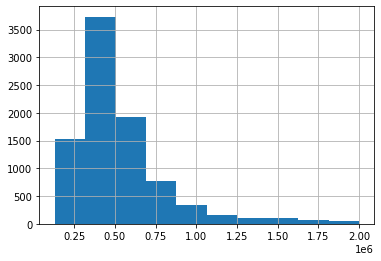

In [26]:
df_trainFold0['actual_price'].hist()

<AxesSubplot: >

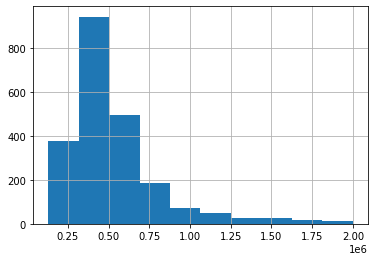

In [27]:
df_testFold0['actual_price'].hist()

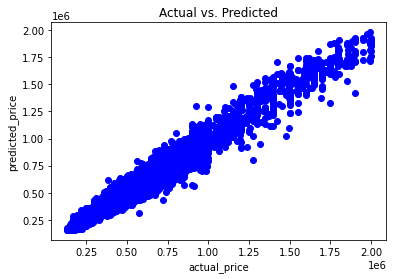

In [28]:
x = original_train['Fold 0']['actual_price']
y = original_train['Fold 0']['predicted_price_comb']

fig, ax = plt.subplots()

# Plot the scatter plot
ax.scatter(x, y, color='blue', marker='o')

# Customize the plot
ax.set_title('Actual vs. Predicted (Train Set)')
ax.set_xlabel('actual_price')
ax.set_ylabel('predicted_price')

# Display the plot
plt.show()

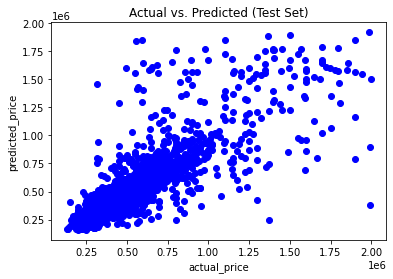

In [29]:
x = original_test['Fold 0']['actual_price']
y = original_test['Fold 0']['predicted_price_comb']

fig, ax = plt.subplots()

# Plot the scatter plot
ax.scatter(x, y, color='blue', marker='o')

# Customize the plot
ax.set_title('Actual vs. Predicted (Test Set)')
ax.set_xlabel('actual_price')
ax.set_ylabel('predicted_price')

# Display the plot
plt.show()

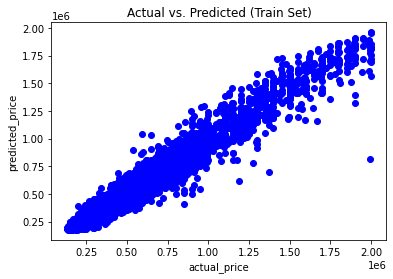

In [30]:
x = original_train['Fold 1']['actual_price']
y = original_train['Fold 1']['predicted_price_comb']

fig, ax = plt.subplots()

# Plot the scatter plot
ax.scatter(x, y, color='blue', marker='o')

# Customize the plot
ax.set_title('Actual vs. Predicted (Train Set)')
ax.set_xlabel('actual_price')
ax.set_ylabel('predicted_price')

# Display the plot
plt.show()

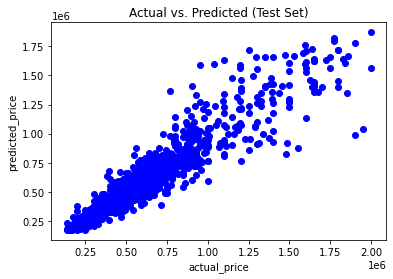

In [31]:
x = original_test['Fold 1']['actual_price']
y = original_test['Fold 1']['predicted_price_comb']

fig, ax = plt.subplots()

# Plot the scatter plot
ax.scatter(x, y, color='blue', marker='o')

# Customize the plot
ax.set_title('Actual vs. Predicted (Test Set)')
ax.set_xlabel('actual_price')
ax.set_ylabel('predicted_price')

# Display the plot
plt.show()

In [81]:
###Applying this concept to all months

In [57]:
df_testFold0[['livingAreaValue', 'lotArea', 'liv/lot_ratio', 'predicted_price/lotsqft', 'predicted_living_price',
               'predicted_price1', 'predicted_price2', 'actual_price']].corr()

,livingAreaValue,lotArea,liv/lot_ratio,predicted_price/lotsqft,predicted_living_price,predicted_price1,predicted_price2,actual_price
livingAreaValue,1.000000,0.099545,0.227420,0.251249,0.516425,0.815181,0.291460,0.751363
lotArea,0.099545,1.000000,-0.348264,-0.308509,-0.230910,0.410999,0.544567,0.311881
liv/lot_ratio,0.227420,-0.348264,1.000000,0.931320,0.820462,0.029587,-0.121296,0.037256
predicted_price/lotsqft,0.251249,-0.308509,0.931320,1.000000,0.843587,0.171559,-0.069824,0.177598
predicted_living_price,0.516425,-0.230910,0.820462,0.843587,1.000000,0.372125,0.108043,0.424987
predicted_price1,0.815181,0.410999,0.029587,0.171559,0.372125,1.000000,0.614398,0.838223
predicted_price2,0.291460,0.544567,-0.121296,-0.069824,0.108043,0.614398,1.000000,0.424126
actual_price,0.751363,0.311881,0.037256,0.177598,0.424987,0.838223,0.424126,1.000000
